Same as final-notebook except this one doesn't keep all objects in the same matrix

In [2]:
# Reading the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187
objectsplit = 13
layersPerObject = endlayer // objectsplit
# Approximate one third test data
testEnd = endlayer - layersPerObject * (objectsplit // 3)

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted

In [10]:
trainobjectinfo.drop(trainobjectinfo[trainobjectinfo.Label == 'KH'].index, inplace=True)
trainobjectinfo.replace('GOOD', 0, inplace=True)
trainobjectinfo.replace('LOF', 1, inplace=True)
trainobjectinfo.reset_index(drop=True, inplace=True)
testobjectinfo.drop(testobjectinfo[testobjectinfo.Label == 'KH'].index, inplace=True)
testobjectinfo.replace('GOOD', 0, inplace=True)
testobjectinfo.replace('LOF', 1, inplace=True)
testobjectinfo.reset_index(drop=True, inplace=True)

trainobjects = np.full((len(trainobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)
testobjects = np.full((len(testobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)

# Double check maybe that iterrows gives the correct order?
for index, object in trainobjectinfo.iterrows():
    trainobjects[index-1] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]
for index, object in testobjectinfo.iterrows():
    testobjects[index-1] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


In [105]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import preprocessing
from datetime import datetime

def preprocess(objects, type, sharpening):
    rtn = np.full(objects.shape, np.nan)
    # print(rtn.shape)
    for index, object in enumerate(objects):
        sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
        sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
    # Sharpening is done
        if type == 'scatter':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            sum = np.sum(sharpened, axis=0)
            limit = np.percentile(sum, emptyRatio)
            filter = sum >= limit
            (endLayer, _, _) = xs.shape
            filter = np.repeat([filter], endLayer, 0)
            xs[~filter] = np.nan
            rtn[index] = xs
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            sum = np.sum(xs, axis=0)
            limit = np.percentile(sum, emptyRatio)
            filter = sum >= limit
            (endLayer, _, _) = xs.shape
            filter = np.repeat([filter], endLayer, 0)
            avg = np.mean(xs, where=filter)
            stddev = np.std(xs, where=filter)
            xs = (xs - avg) / avg
            xs[~filter] = np.nan
            rtn[index] = xs
        elif type == 'spatstat':
            # Implement later
            print("nyi")
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    c, z, y, x = objects.shape

    outlierValues = np.full((c, z + 1 - windowSize, y, x), np.nan)
    for index, object in enumerate(objects):
        # Step 1: calculate neighbourhood
        neighbourkernel = np.array(
            [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
        )/9 if neighbourhoodSetting == 'grid' else np.array(
            [[1, 2,  1],
            [2, 4, 2],
            [1, 2,  1]])/16
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1
        init = False

        if type == 'spatstat':
            print("nyi")
        else:
            # Is the axis right for moran/scatter?
            # print(offset, endoffset, object.shape)
            xs = object[offset:z-endoffset]
            ys = neighbourhoodValues[0:z-windowSize+1]
            filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))
            line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
            p = np.poly1d(line)
            outlierValues[index] = xs - p(ys)
            assert(len(set(filter.flatten())) == 2)
            assert(len(np.unique(outlierValues[index])) > 1)
            assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
            assert(outlierValues[index].shape == xs.shape == p(ys).shape)
    assert(np.average(np.isfinite(outlierValues)) > 0.4)
    return outlierValues

def encode(outlierobjects, type, buckets, histnormalise, minval=0, maxval=0):
    # Note: remove KF objects at some point...
    init = False

    numberOfObjects, _, _, _ = outlierobjects.shape
    X = np.full((numberOfObjects, buckets), np.nan)
    if type == 'spatstat':
        print("nyi")
    else:
        filter = np.isfinite(outlierobjects)
        minval = np.min(outlierobjects[filter]) if minval == 0 else minval
        maxval = np.max(outlierobjects[filter]) if maxval == 0 else maxval
        for index in range(0, numberOfObjects):
            xs = outlierobjects[index]
            filter = np.isfinite(xs)
            hist, _ = np.histogram(xs[filter], bins=buckets, range=(minval, maxval))
            X[index] = np.array(hist)
        
        if (histnormalise == 'column'):
            X = preprocessing.normalize(X, axis=0)
        elif (histnormalise == 'row'):
            X = preprocessing.normalize(X, axis=1)
    return X, minval, maxval

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict(Xtest)
    return metrics.roc_auc_score(Ytest, yfit), metrics.precision_score(Ytest, yfit, zero_division=0), metrics.recall_score(Ytest, yfit, zero_division=0)

In [69]:
# Tweaking parameter settings
types = ['moran', 'scatter']
# types = ['scatter', 'moran', 'spatstat']
sharpening = ['direct', 'diagonal']
neighbourhoodSetting = ['grid', 'euclidean']
windowsizes = range(1, 8, 2)
buckets = range(30, 151, 30)
histnormalise = ('none', 'row')
#bucket-lower-limit?
k = range(2, 7)

In [107]:
# Now to tie it all together...
columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'auc', 'precision', 'recall']
results = pd.DataFrame(columns=columns)
Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
Ytest = np.array(testobjectinfo.loc[:,"Label"])
print(set(Ytest), set(Ytrain))
for type in types:
    print(datetime.now(), "type: ", type)
    for sharpSetting in sharpening:
        print(datetime.now(), "sharpSetting: ", sharpSetting)
        # trainpreprocessed = np.apply_along_axis(preprocess, 1, trainobjects, type, sharpSetting)
        trainpreprocessed =preprocess(trainobjects, type, sharpSetting)
        testpreprocessed =preprocess(testobjects, type, sharpSetting)
        for windowsize in windowsizes:
            print(datetime.now(), "windowsize: ", windowsize)
            for nSetting in neighbourhoodSetting:
                print(datetime.now(), "nSetting: ", nSetting)
                # trainoutliers = np.apply_along_axis(calculateoutliers, 1, trainpreprocessed, type, nSetting, windowsize)
                trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
                testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
                
                for histnorm in histnormalise:
                    for bucket in buckets:
                        print(datetime.now(), "histnorm: ", histnorm, "bucket: ", bucket)
                        Xtrain, minval, maxval = encode(trainoutliers, type, bucket, histnorm)
                        Xtest, _, _ = encode(testoutliers, type, bucket, histnorm, minval=minval, maxval=maxval)
                        # Add encode for test as well
                        for n_neighbors in k:
                            score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
                            nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bucket, histnorm, n_neighbors, score, precision, recall]], columns=columns)
                            results = pd.concat([results, nextRow])
                        results.to_csv('out2.csv', index=False, header=True)


{0, 1} {0, 1}
2022-09-13 13:54:24.619297 type:  moran
2022-09-13 13:54:24.619313 sharpSetting:  direct
2022-09-13 13:54:25.139770 windowsize:  1
2022-09-13 13:54:25.139888 nSetting:  grid
2022-09-13 13:54:29.492074 histnorm:  none bucket:  30
2022-09-13 13:54:29.980904 histnorm:  none bucket:  60
2022-09-13 13:54:30.449430 histnorm:  none bucket:  90
2022-09-13 13:54:30.914510 histnorm:  none bucket:  120
2022-09-13 13:54:31.463169 histnorm:  none bucket:  150
2022-09-13 13:54:31.927954 histnorm:  row bucket:  30
2022-09-13 13:54:32.565872 histnorm:  row bucket:  60
2022-09-13 13:54:33.073507 histnorm:  row bucket:  90
2022-09-13 13:54:33.592010 histnorm:  row bucket:  120
2022-09-13 13:54:34.099401 histnorm:  row bucket:  150
2022-09-13 13:54:34.638415 nSetting:  euclidean
2022-09-13 13:54:39.092272 histnorm:  none bucket:  30
2022-09-13 13:54:39.585390 histnorm:  none bucket:  60
2022-09-13 13:54:40.050028 histnorm:  none bucket:  90
2022-09-13 13:54:40.505783 histnorm:  none bucket:

train 2 outliers:  [-0.8649039  -0.81811556 -0.76877875 ...  2.88366474  3.15628115
         nan]
test 2 outliers:  [-0.93347341 -0.82556182 -0.79341662 ...  1.67699473  1.74934352
         nan]
train 1 outliers:  [-0.88628136 -0.77474869 -0.71723599 ...  1.08783357  2.00141611
         nan]
test 1 outliers:  [-0.82612948 -0.79183348 -0.7770636  ...  1.20228772  1.26646023
         nan]
train 2 outliers:  [-0.8649039  -0.81811556 -0.76877875 ...  2.88366474  3.15628115
         nan]
test 2 outliers:  [-0.93347341 -0.82556182 -0.79341662 ...  1.67699473  1.74934352
         nan]
train 1 outliers:  [-0.88628136 -0.77474869 -0.71723599 ...  1.08783357  2.00141611
         nan]
test 1 outliers:  [-0.82612948 -0.79183348 -0.7770636  ...  1.20228772  1.26646023
         nan]


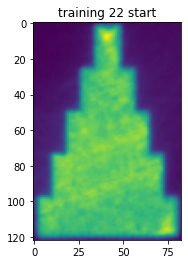

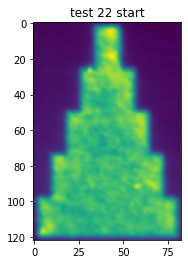

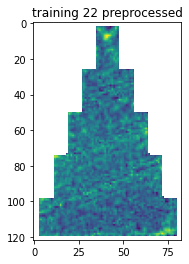

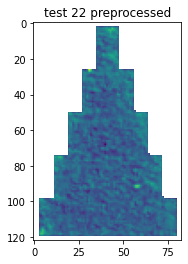

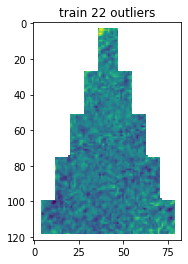

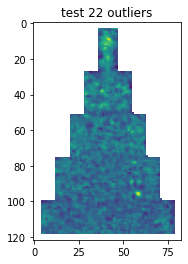

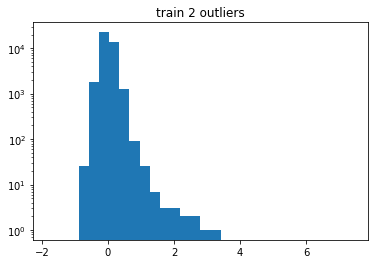

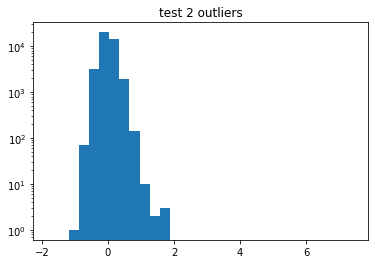

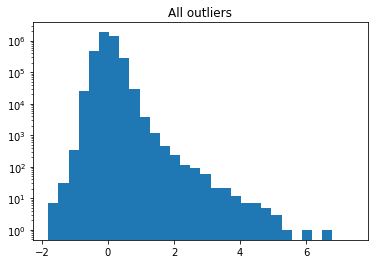

<Figure size 432x288 with 0 Axes>

In [106]:
# Debug cell

type = "moran"
sharpSetting = "diagonal"
windowSize = 5
histnorm = "none"
bucket = 30
nSetting = "euclidean"

columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'auc', 'precision', 'recall']
results = pd.DataFrame(columns=columns)
Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
Ytest = np.array(testobjectinfo.loc[:,"Label"])

# Att validera:
# Träningsset har flera klasser
# Testset har flera klasses
# Bilder i varje steg
assert(set(Ytest) == set(Ytrain))
# trainpreprocessed = np.apply_along_axis(preprocess, 1, trainobjects, type, sharpSetting)
trainpreprocessed = preprocess(trainobjects, type, sharpSetting)
testpreprocessed = preprocess(testobjects, type, sharpSetting)

plt.title("training 22 start")
plt.imshow(trainobjects[2][2])
plt.figure()
plt.title("test 22 start")
plt.imshow(testobjects[2][2])
plt.figure()
plt.title("training 22 preprocessed")
plt.imshow(trainpreprocessed[2][2])
plt.figure()
plt.title("test 22 preprocessed")
plt.imshow(testpreprocessed[2][2])
plt.figure()
# trainoutliers = np.apply_along_axis(calculateoutliers, 1, trainpreprocessed, type, nSetting, windowsize)
trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
print("train 2 outliers: ", np.unique(trainoutliers[2]))
print("test 2 outliers: ", np.unique(testoutliers[2]))
print("train 1 outliers: ", np.unique(trainoutliers[1]))
print("test 1 outliers: ", np.unique(testoutliers[1]))
plt.title("train 22 outliers")
plt.imshow(trainoutliers[2][2])
plt.figure()
plt.title("test 22 outliers")
plt.imshow(testoutliers[2][2])
plt.figure()
Xtrain, minval, maxval = encode(trainoutliers, type, bucket, histnorm)
Xtest, _, _ = encode(testoutliers, type, bucket, histnorm, minval=minval, maxval=maxval)
print("train 2 outliers: ", np.unique(trainoutliers[2]))
print("test 2 outliers: ", np.unique(testoutliers[2]))
print("train 1 outliers: ", np.unique(trainoutliers[1]))
print("test 1 outliers: ", np.unique(testoutliers[1]))
plt.title("train 2 outliers")
plt.hist(trainoutliers[2].flatten(), bins=bucket, range=(minval, maxval))
plt.yscale('log')
plt.figure()
plt.title("test 2 outliers")
plt.hist(testoutliers[2].flatten(), bins=bucket, range=(minval, maxval))
plt.yscale('log')
plt.figure()
plt.title("All outliers")
plt.hist(testoutliers.flatten(), bins=bucket, range=(minval, maxval))
plt.yscale('log')
plt.figure()
# Add encode for test as well
for n_neighbors in k:
    score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
    nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bucket, histnorm, n_neighbors, score, precision, recall]], columns=columns)
    results = pd.concat([results, nextRow])
results.to_csv('out2.csv', index=False, header=True)
